In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from target_encoding import TargetEncoderClassifier, TargetEncoder
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import json
from functools import partial
from dsb2019.models.coeff import ThresholdClassifier

from dsb2019.models.tracking import track_experiment, track_submission_info
from dsb2019.data.validation import InstallationFold, cross_validate, quad_kappa
from dsb2019.visualization import session_browser
from dsb2019.data import DATA_DIR
from dsb2019.data import adv_validation
from dsb2019.models import MODELS_DIR
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import hyperopt
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
from multiprocessing import cpu_count
from joblib import Parallel, delayed

tqdm.pandas()
pd.options.display.max_rows=999

In [3]:
train = pd.read_csv(DATA_DIR / 'raw/train.csv')
test = pd.read_csv(DATA_DIR / 'raw/test.csv')
train_labels = pd.read_csv(DATA_DIR / 'raw/train_labels.csv')
submission = pd.read_csv(DATA_DIR / 'raw/sample_submission.csv')

In [4]:
games = ['Scrub-A-Dub', 'All Star Sorting',
       'Air Show', 'Crystals Rule', 
       'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time',
       'Pan Balance', 'Happy Camel',
       'Leaf Leader']
assessments = ['Mushroom Sorter (Assessment)',
       'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)',
       'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)']
worlds = ['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']

def unwrap_event_data(df):
    unwrapped=pd.DataFrame(data=list(df.event_data.apply(json.loads).values))
    unwrapped.drop("event_code", axis=1, inplace=True)
    return pd.concat([unwrapped.reset_index(),df.reset_index()],axis=1)


event_data_features = ["duration", "round", "level", "position", "total_duration", "weight", "misses"]


def extract_basic_stats(df):
    stats = ["min", "max", "mean", "std"]
    df = df[[f for f in event_data_features if f in df.columns]].reindex(columns=event_data_features)
    result = []
    for column, stats in df.agg(stats).to_dict().items():
        result.extend([(k+"_"+column, v) for k,v in stats.items()])
    return result


def extract_chow_time(df):
    cols = ["round", "event_id", "resources", "target_weight", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="63f13dd7"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"optimum":None, "complete": 0})
        resources = data["resources"]
        target = data["target_weight"]
        optimum = 0
        cnt = 0
        for v in sorted(resources)[::-1]:
            if v+cnt>target:
                continue
            else:
                cnt+=v
                optimum+=1
                if cnt==target:
                    break
        n_turns = sum(df.event_id=="4ef8cdd3")
        complete = sum(df.event_id=="56817e2b")
        return pd.Series({"optimum":n_turns / optimum, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("chowtime_optimum", None), ("chowtime_complete", None)]
    return [("chowtime_optimum", feature["optimum"]), ("chowtime_complete", feature["complete"])]


def extract_leaf_leader(df):
    cols = ["round", "event_id", "target_weight", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="f32856e4"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"optimum": None, "complete": 0})
        target = data["target_weight"]
        optimum = 0
        cnt = 0
        for v in [4, 4, 2, 2, 2, 2, 1, 1]:
            if v+cnt>target:
                continue
            else:
                cnt+=v
                optimum+=1
                if cnt==target:
                    break
        n_turns = sum(df.event_id=="262136f4")
        complete = sum(df.event_id=="b012cd7f")
        return pd.Series({"optimum": n_turns / optimum, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("leafleader_optimum", None), ("leafleader_complete", None)]
    return [("leafleader_optimum", feature["optimum"]), ("leafleader_complete", feature["complete"])]


def extract_happy_camel(df):
    cols = ["round", "event_id", "has_toy", "bowls", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="c2baf0bd"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({'optimum':None, 'n_toy_detected':None, "complete":0})
    
        optimum = len(data["bowls"])
        turns = df[df.event_id=="6bf9e3e1"]
        n_turns = len(turns)
        n_toy_detected = turns["has_toy"].sum()
        complete = sum(df.event_id=="36fa3ebe")
        return pd.Series({'optimum':(n_turns / optimum), 'n_toy_detected':n_toy_detected, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("happycamel_optimum", None), ("happycamel_detections", None), 
                ("happycamel_complete", None)]

    return [("happycamel_optimum", feature["optimum"]), ("happycamel_detections", feature["n_toy_detected"]), 
            ("happycamel_complete", feature["complete"])]


def extract_pan_balance(df):
    cols = ["round", "event_id", "target_weight", "starting_weights", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="a592d54e"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"optimum": None, "complete": 0})
        target = data["target_weight"]
        start = data["starting_weights"]
        optimum = max(abs(target - start), 1)
        n_turns = sum(df.event_id.isin(("e7561dd2", "804ee27f")))
        complete = sum(df.event_id=="1c178d24")
        return pd.Series({"optimum": n_turns / optimum, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("panbalance_optimum", None), ("panbalance_complete", None)] 
    return [("panbalance_optimum", feature["optimum"]), ("panbalance_complete", feature["complete"])]


def extract_scrubadub(df):
    cols = ["round", "event_id", "game_session", "correct", "event_code", "animals"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="26fd2d99"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance":None, "precision": None, "complete": 0})
        n_animals = len(data["animals"])
        complete = sum(df.event_id=="08fd73f3")
        df = df[(df.event_id=="5c3d2b2f")&(df.event_code==4020)]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("scrubadub_performance", None), ("scrubadub_precision", None), ("scrubadub_complete", None)]
    return [("scrubadub_performance", feature["performance"]), ("scrubadub_precision", feature["precision"]),
            ("scrubadub_complete", feature["complete"])]    


def extract_allstarsorting(df):
    cols = ["round", "event_id", "game_session", "correct", "event_code", "houses"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="2c4e6db0"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance":None, "precision": None, "complete": 0})
        n_animals = len(data["houses"])
        complete = sum(df.event_id=="ca11f653")
        df = df[df.event_id=="2dc29e21"]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("allstarsorting_performance", None), ("allstarsorting_precision", None), ("allstarsorting_complete", None)]
    return [("allstarsorting_performance", feature["performance"]), ("allstarsorting_precision", feature["precision"]),
            ("allstarsorting_complete", feature["complete"])]  


def extract_dinodrink(df):
    cols = ["round", "event_id", "game_session", "correct", "event_code", "holes"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="f806dc10"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance": None, "precision": None, "complete": 0})
        n_animals = len(data["holes"])
        complete = sum(df.event_id=="16dffff1")
        df = df[df.event_id=="74e5f8a7"]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("dinodrink_performance", None), ("dinodrink_precision", None), ("dinodrink_complete", None)]
    return [("dinodrink_performance", feature["performance"]), ("dinodrink_precision", feature["precision"]),
            ("dinodrink_complete", feature["complete"])]  


def extract_bubblebath(df):
    cols = ["round", "event_id", "game_session", "containers", "target_containers"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="1beb320a"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance": None, "complete": 0})
        target = data["target_containers"]
        complete = sum(df.event_id=="895865f3")
        df = df[df.event_id=="3bb91dda"]
        if len(df):
            return pd.Series({"performance": abs(target - df.iloc[0]["containers"]), "complete": complete})
        else:
            return pd.Series({"performance": None, "complete": 0})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if isinstance(feature, pd.Series):
        return [("bubblebath_performance", None), ("bubblebath_complete", None)]
    return [("bubblebath_performance", feature["performance"]), ("bubblebath_complete", feature["complete"])] 


def extract_dinodive(df):
    cols = ["round", "event_id", "game_session", "correct", "target_water_level"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="7961e599"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance": None, "precision": None, "complete": 0})
        target = data["target_water_level"]
        dinos = [6, 6, 3, 3, 3, 3, 1, 1]
        opt=0
        n_animals=0
        for d in dinos:
            if opt+d>target:
                continue
            else:
                opt+=d
                n_animals+=1
                if opt==target:
                    break
        complete = sum(df.event_id=="00c73085")
        df = df[df.event_id=="c0415e5c"]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("dinodive_performance", None), ("dinodive_precision", None), ("dinodive_complete", None)]
    return [("dinodive_performance", feature["performance"]), ("dinodive_precision", feature["precision"]),
            ("dinodive_complete", feature["complete"])]


def extract_airshow(df):
    cols = ["round", "event_id", "game_session", "correct"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        complete =sum(df.event_id=="f5b8c21a")
        df = df[df.event_id=="28f975ea"]
        return pd.Series({"performance": len(df), "precision": df["correct"].sum(), "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("airshow_performance", None), ("airshow_precision", None), ("airshow_complete", None)]
    return [("airshow_performance", feature["performance"]), ("airshow_precision", feature["precision"]),
            ("airshow_complete", feature["complete"])]      


def extract_crystalsrule(df):
    cols = ["round", "event_id", "game_session", "correct"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        complete = sum(df.event_id=="3323d7e9")
        df = df[df.event_id=="86c924c4"]
        return pd.Series({"performance": len(df), "precision": df["correct"].sum(), "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("crystalsrule_performance", None), ("crystalsrule_precision", None), ("crystalsrule_complete", None)]
    return [("crystalsrule_performance", feature["performance"]), ("crystalsrule_precision", feature["precision"]),
            ("crystalsrule_complete", feature["complete"])]          


game_funcs={
    "Chow Time": extract_chow_time,
    "Leaf Leader": extract_leaf_leader,
    "Happy Camel": extract_happy_camel,
    "Pan Balance": extract_pan_balance,
    "Scrub-A-Dub": extract_scrubadub,
    "All Star Sorting": extract_allstarsorting,
    "Dino Drink": extract_dinodrink,
    "Bubble Bath": extract_bubblebath,
    "Dino Dive": extract_dinodive,
    "Air Show": extract_airshow,
    "Crystals Rule": extract_crystalsrule,
}


def extract_game_stats(df, title):
    return game_funcs[title](df)


def make_counters(df, column):
    return {k: v for k, v in df.groupby(column)[column].count().to_dict().items()}


def make_round_counters(df, column):
    df = df[[c for c in df.columns if c in [column, "round", "game_session"]]].reindex(columns=[column, "round", "game_session"])
    df = df.groupby([column, "round", "game_session"])[column].count().to_frame(name="cnt").reset_index()
    return {k: v for k,v in df.groupby(column)["cnt"].mean().to_dict().items()}


def interactions(features):
    fnames = sorted(features.keys())
    result = {}
    for i, fa in enumerate(fnames):
        for j in range(i+1, len(fnames)):
            fb = fnames[j]
            fname = f"{fa}_interaction_{fb}"
            result[fname] = features[fa] / features[fb]
    return result

    
def process_log(df):
    current_session=df.game_session.iloc[-1]
    assessment_title=df.title.iloc[-1]   
    world=df.world.iloc[-1]

    history = df.iloc[:-1]
    movies = history[history.type=="Clip"]
    #history = history[history.type.isin(["Game", "Assessment"])]
    
    history = history[history.event_id.isin(all_events)].copy()
    
    def calculate_ratios(df):
        n_correct=df.correct_move.sum()
        n_incorrect=df.wrong_move.sum()
        ratio=n_correct/(n_correct+n_incorrect)
        return n_correct, n_incorrect, ratio
    
    def make_move_stats(df, title,n_lags=2):
        df=df.copy()
        if len(df):
            df = unwrap_event_data(df)
        if "correct" in df.columns:
            df["correct_move"] = df.correct == True
            df["wrong_move"] = df.correct == False
        else:
            df["correct_move"]=False
            df["wrong_move"]=False
        result = []
        result.extend(zip([f"n_correct_{title}", f"n_incorrect_{title}", f"global_ratio_{title}"], calculate_ratios(df)))
        result.extend(extract_game_stats(df, title))
        #result.extend(extract_basic_stats(df))
        if n_lags:
            last_sessions = df.game_session.unique()[-n_lags:]
            for i in range(n_lags):
                if i < len(last_sessions): 
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title} {i}",f"ratio_{title}_{i}"], 
                                      calculate_ratios(df[df.game_session==last_sessions[i]])))
                else:
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title}_{i}",f"ratio_{title}_{i}"], [None, None, None]))
        return {k: v for k, v in result}, df
    
    
    result = {"title": assessments.index(assessment_title),
              "world": worlds.index(world),
              "n_activities": df[df.type=="Activity"].game_session.nunique(),
              "n_games": df[df.type=="Game"].game_session.nunique(),
              "event_code_count": df.event_code.nunique(),
              "event_id_count": df.event_id.nunique(),
              "title_count": df.title.nunique(),
              "n_actions": len(df),
              "world_title_count": df[df.world==world].title.nunique(),
             }
    
    def make_game_features(game):
        result = {}
        stats=history[history.title==game]
        stats_features, stats = make_move_stats(stats, game)
        stats_features[f"{game}_event_code_count"] = stats.event_code.nunique()
        stats_features[f"{game}_event_id_count"] = stats.event_id.nunique()
        stats_features[f"{game}_session_id_count"] = stats.game_session.nunique()
        stats_features[f"{game}_n_actions"] = len(stats)
        result.update(stats_features)
        counters = {f"{game}_{k}": v for k, v in make_counters(stats, "event_id").items()}
        result.update(counters)
        #result.update(interactions(counters))
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
        return result
    
    for f in Parallel(n_jobs=cpu_count())(delayed(make_game_features)(game) for game in games):
        result.update(f)
    #for game in games:
    #    result.update(make_game_features(game))
    world_games = history[history.world==world]
    
    def make_world_features(game):
        result = {}
        stats=world_games[world_games.title==game]
        stats_features, stats=make_move_stats(stats, game)
        stats_features = {f"world_{k}": v for k, v in stats_features.items()}
        stats_features[f"world_{game}_event_code_count"] = stats.event_code.nunique()
        stats_features[f"world_{game}_event_id_count"] = stats.event_id.nunique()
        stats_features[f"world_{game}_session_id_count"] = stats.game_session.nunique()
        stats_features[f"world_{game}_n_actions"] = len(stats)
        result.update(stats_features)
        counters = {f"world_{game}_{k}": v for k, v in make_counters(stats, "event_id").items()}
        result.update(counters)
        #result.update(interactions(counters))
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
        return result
    
    result.update({f"world_{k}": v for k, v in make_counters(world_games, "event_id").items()})
    
    world_games["event_id"] = world_games["event_id"].map(event_replacements)
    result.update({f"world_reduced_{k}": v for k, v in make_counters(world_games, "event_id").items()})
    
    result.update({f"world_{k}": v for k, v in make_counters(world_games, "event_code").items()})
    
    for f in Parallel(n_jobs=cpu_count())(delayed(make_world_features)(game) for game in games):
        result.update(f)
    #for game in games:
    #    result.update(make_world_features(game))
    #make_history_counters = partial(make_counters, history)
    result.update(make_counters(history, "event_id"))
    history["event_id"] = history["event_id"].map(event_replacements)
    result.update({f"reduced_{k}": v for k, v in make_counters(history, "event_id").items()})
    #result.update(interactions(counters))
    result.update(make_counters(history, "event_code"))
    #result.update(make_counters(movies, "title"))
    return result

In [5]:
def process_installations(train_labels, train, process_log):
    result = []
    train=train.sort_values("timestamp")
    installations = train.groupby("installation_id")
    for i, game_session, title, installation_id, accuracy_group in tqdm(train_labels[["game_session", "title", "installation_id", "accuracy_group"]].itertuples(), 
                                                              total=len(train_labels), position=0):
        player_log = installations.get_group(installation_id).reset_index()
        player_log = player_log.sort_values("timestamp")
        log_length = player_log[(player_log.game_session==game_session) & (player_log.title==title)].index[0]
        player_log = player_log.iloc[:(log_length + 1)]
        player_log["accuracy_group"] = accuracy_group
        player_log["target_game_session"] = game_session
        features = process_log(player_log)
        features["installation_id"] = installation_id
        features["accuracy_group"] = accuracy_group
        result.append(features)
    return pd.DataFrame(data=result).fillna(-1)

In [ ]:
train_features = process_installations(train_labels, train, process_log)

  0%|          | 0/17690 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:928: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  1%|          | 202/17690 [01:29<2:10:32,  2.23it/s]

In [ ]:
#np.corrcoef(train_features["airshow_precision"], train_features["world_airshow_precision"])[0][1]

In [ ]:
#train_features[[c for c in train_features.columns if isinstance(c, str) and ("crystalsrule" in c)]]

In [ ]:
bad_features = ["session_id_count", "event_id_count", "mean_round", "n_actions", "n_activities"]

In [ ]:
def get_duplicate_features(features, bad_features):
    to_remove = set([])
    counter = 0
    feature_names=[f for f in features.columns if f not in ("installation_id", "game_session", "accuracy_group")]
    for feat_a in tqdm(feature_names):
        for feat_b in feature_names:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(features[feat_a], features[feat_b])[0][1]
                if c > 0.995:
                    counter += 1
                    to_remove.add(feat_b)
                    if feat_b in bad_features or feat_a in bad_features:
                        to_remove.add(feat_a)
                    #print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    for bf in bad_features:
        to_remove.add(bf)
    print(f"{len(to_remove)} features were removed ({round(len(to_remove)/len(feature_names)*100, 2)}% of all features)")
    return list(to_remove)
    
duplicate_features = get_duplicate_features(train_features, bad_features)

useful_features = [f for f in train_features.columns if f not in duplicate_features]
useful_features

In [ ]:
train_features=train_features[useful_features].copy()

In [ ]:
def lgb_quad_kappa(preds, true):
    true = true.get_label()
    #preds = preds.reshape((4, -1)).argmax(axis=0)
    preds = np.rint(preds)
    preds = np.maximum(0, preds)
    preds = np.minimum(3, preds)
    return "quad_kappa", quad_kappa(true, preds), True
    
    
def train_baseline(x_train,y_train, params=None):
    x_train_all, x_val_all,y_train_all,y_val_all = train_test_split(
        x_train,y_train,
        test_size=0.15,
        random_state=2019,
    )
    train_set = lgb.Dataset(x_train_all, y_train_all)
    val_set = lgb.Dataset(x_val_all, y_val_all)

#     params = {
#         'learning_rate': 0.01,
#         'bagging_fraction': 0.9,
#         'feature_fraction': 0.9,
#         'num_leaves': 14,
#         'lambda_l1': 0.1,
#         'lambda_l2': 1,
#         'metric': 'multiclass',
#         'objective': 'multiclass',
#         'num_classes': 4,
#         'random_state': 2019
#     }

    return lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=2000, valid_sets=[val_set], verbose_eval=100)#,
                    #feval=lgb_quad_kappa)

def make_features(df):
    return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values

def make_features_wrapper(train, test):
    def make_features(df):
        return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values
    
    return make_features(train), make_features(test) 


def make_predictions(model,x_test_all,y_test):
    preds=model.predict(x_test_all)
    #preds = np.rint(preds)
    #preds = np.maximum(0, preds)
    #preds = np.minimum(3, preds)
    return preds,y_test

In [ ]:
def process_test_installations(test):
    test = test.sort_values("timestamp")
    test=test.groupby("installation_id").progress_apply(process_log).reset_index()
    test.columns = ["installation_id", "features"]
    result = []
    for i, installation_id, feature in test.itertuples():
        result.append(feature)
        feature["installation_id"]=installation_id
    return pd.DataFrame(result).fillna(-1)
test_features=process_test_installations(test)

for useful_feature in useful_features:
    if useful_feature not in test_features.columns:
        test_features[useful_feature]=-1
        print("Missing feature", useful_feature)

test_features=test_features[[c for c in useful_features if c != "accuracy_group"]].copy()

In [ ]:
!ls ../dsb2019/models

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's auc: 0.648541
[200]	valid_0's auc: 0.645677
[300]	valid_0's auc: 0.649153
[400]	valid_0's auc: 0.646782
[500]	valid_0's auc: 0.648254
[600]	valid_0's auc: 0.645878
[700]	valid_0's auc: 0.647224
[800]	valid_0's auc: 0.643642
[900]	valid_0's auc: 0.648174
[1000]	valid_0's auc: 0.647631
[1100]	valid_0's auc: 0.647827
[1200]	valid_0's auc: 0.647139
[1300]	valid_0's auc: 0.648134
[1400]	valid_0's auc: 0.647481
[1500]	valid_0's auc: 0.648033
[1600]	valid_0's auc: 0.646868
[1700]	valid_0's auc: 0.64734
[1800]	valid_0's auc: 0.647933
[1900]	valid_0's auc: 0.648867
[2000]	valid_0's auc: 0.649118
Early stopping, best iteration is:
[5]	valid_0's auc: 0.660472
0.6550638664016675


/opt/conda/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


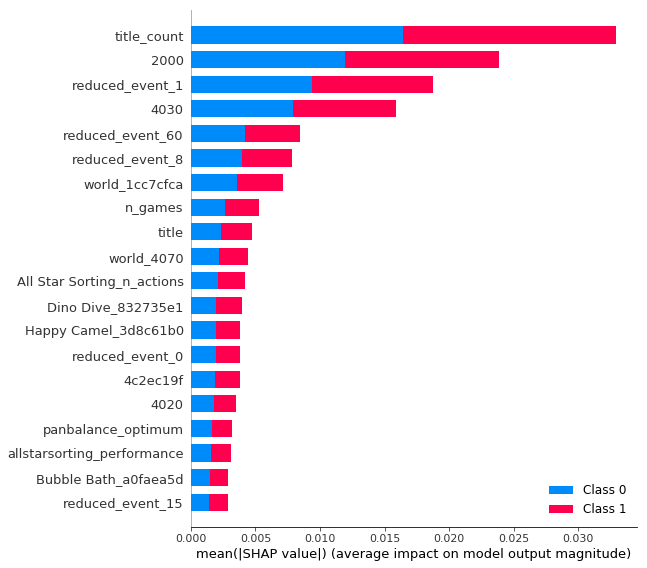

In [21]:
with open("../dsb2019/models/regression_norm_params.json", "r") as f:
    validator_params=json.load(f)
selected_features = [f for f in train_features.columns if f not in ["installation_id", "game_session", "accuracy_group"]]
validator = adv_validation.AdversarialValidator(validator_params, train_features, test_features, selected_features=selected_features,test_size=0.5)
validator.fit()
print(validator.roc_auc())
validator.shap_important_features()

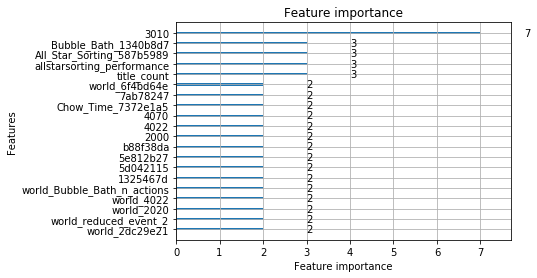

In [19]:
validator.lgb_important_features()

In [22]:
subtrain_installations=pd.Series(train_features.installation_id.unique()).sample(frac=1., random_state=2019)
subtrain_features=train_features[train_features.installation_id.isin(subtrain_installations.values)].copy()
def check_hyperparams(params):
    print(params)
    if "max_depth" in params:
        params["max_depth"] = int(params["max_depth"])
    if "num_leaves" in params:
        params["num_leaves"] = int(params["num_leaves"])

    train_baseline_with_params = partial(train_baseline, params=params)
    cv=InstallationFold(n_splits=3)
    predictions = cross_validate(subtrain_features, subtrain_features.accuracy_group, make_features_wrapper, train_baseline_with_params, make_predictions,
                                cv=cv)
    return {
        "loss": np.mean([mean_squared_error(true, pred) for pred, true in predictions]),
        "status": STATUS_OK,
        "params": params
    }


def tune(check_params, n_tries=25, n_learning_rate_tries=15, learning_rate=None, n_estimators=10_000):        
    if learning_rate is None:
        learning_rate_space = {
            'learning_rate': hp.loguniform("learning_rate", np.log(0.005), np.log(0.3)),
            'metric': 'rmse',
            'objective': 'rmse',
            #'num_classes': 4,
            'random_state': 2019,
            "n_estimators": n_estimators,

        }
        trials = Trials()
        result = fmin(check_params,
                      learning_rate_space, tpe.suggest, n_learning_rate_tries, trials=trials)
        print(result)
        learning_rate = round(trials.best_trial["result"]["params"]["learning_rate"], 3)

    param_space = {
        'metric': 'rmse',
        'objective': 'rmse',
        #'num_classes': 4,
        'lambda_l1': hp.uniform("lamba_l1", 1e-10, 1),
        'lambda_l2': hp.uniform("lambda_l2", 1e-10, 1),
        'random_state': 2019,
        "n_estimators": n_estimators,
        "learning_rate": learning_rate,
        "max_depth": hp.quniform("max_depth", 2, 16, 1),
        "num_leaves": hp.choice("num_leaves", [3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]),
        "subsample": hp.quniform("subsample", 0.01, 1, 0.01),
        "feature_fraction": hp.quniform("feature_fraction", 0.01, 1, 0.01),
    }

    trials = Trials()
    fmin(check_params,
         param_space, tpe.suggest, n_tries, trials=trials)
    best_params = trials.best_trial["result"]["params"]
    return best_params

In [23]:
best_params=tune(check_hyperparams, n_tries=100, n_learning_rate_tries=10)

{'learning_rate': 0.05999724498705228, 'metric': 'rmse', 'n_estimators': 10000, 'objective': 'rmse', 'random_state': 2019}
  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.00682                       
[200]	valid_0's rmse: 1.00277                       
[300]	valid_0's rmse: 1.0067                        
[400]	valid_0's rmse: 1.01262                       
[500]	valid_0's rmse: 1.01788                       
[600]	valid_0's rmse: 1.01998                       
[700]	valid_0's rmse: 1.02462                       
[800]	valid_0's rmse: 1.02745                       
[900]	valid_0's rmse: 1.03106                       
[1000]	valid_0's rmse: 1.03397                      
[1100]	valid_0's rmse: 1.0366                       
[1200]	valid_0's rmse: 1.03958                      
[1300]	valid_0's rmse: 1.04183                      
[1400]	valid_0's rmse: 1.04394                      
[1500]	valid_0's rmse: 1.04561                      
[1600]	valid_0's rmse: 1.04802                      
[1700]	valid_0's rmse: 1.04921                      
[1800]	valid_0's rmse: 1.05097      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.06852                                                
[200]	valid_0's rmse: 1.03288                                                
[300]	valid_0's rmse: 1.01782                                                
[400]	valid_0's rmse: 1.00882                                                
[500]	valid_0's rmse: 1.00423                                                
[600]	valid_0's rmse: 1.00232                                                
[700]	valid_0's rmse: 1.00096                                                
[800]	valid_0's rmse: 1.00015                                                
[900]	valid_0's rmse: 1.00051                                                
[1000]	valid_0's rmse: 1.00153                                               
[1100]	valid_0's rmse: 1.00181                                               
[1200]	valid_0's rmse: 1.00231                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds               
[100]	valid_0's rmse: 1.13125                                                
[200]	valid_0's rmse: 1.07819                                                
[300]	valid_0's rmse: 1.05249                                                
[400]	valid_0's rmse: 1.03867                                                
[500]	valid_0's rmse: 1.02967                                                
[600]	valid_0's rmse: 1.02241                                                
[700]	valid_0's rmse: 1.0174                                                 
[800]	valid_0's rmse: 1.01297                                                
[900]	valid_0's rmse: 1.00986                                                
[1000]	valid_0's rmse: 1.00732                                               
[1100]	valid_0's rmse: 1.00552                                               
[1200]	valid_0's rmse: 1.00387                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.13493                                                 
[200]	valid_0's rmse: 1.08208                                                 
[300]	valid_0's rmse: 1.05551                                                 
[400]	valid_0's rmse: 1.04131                                                 
[500]	valid_0's rmse: 1.03193                                                 
[600]	valid_0's rmse: 1.02455                                                 
[700]	valid_0's rmse: 1.01946                                                 
[800]	valid_0's rmse: 1.01476                                                 
[900]	valid_0's rmse: 1.01143                                                 
[1000]	valid_0's rmse: 1.00871                                                
[1100]	valid_0's rmse: 1.00698                                                
[1200]	valid_0's rmse: 1.00559                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.00797                                                 
[200]	valid_0's rmse: 1.02243                                                 
[300]	valid_0's rmse: 1.0327                                                  
[400]	valid_0's rmse: 1.04165                                                 
[500]	valid_0's rmse: 1.04764                                                 
[600]	valid_0's rmse: 1.05465                                                 
[700]	valid_0's rmse: 1.05883                                                 
[800]	valid_0's rmse: 1.06312                                                 
[900]	valid_0's rmse: 1.06499                                                 
[1000]	valid_0's rmse: 1.06782                                                
[1100]	valid_0's rmse: 1.07004                                                
[1200]	valid_0's rmse: 1.07227                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.0588                                                  
[200]	valid_0's rmse: 1.02684                                                 
[300]	valid_0's rmse: 1.01165                                                 
[400]	valid_0's rmse: 1.00453                                                 
[500]	valid_0's rmse: 1.0008                                                  
[600]	valid_0's rmse: 0.998848                                                
[700]	valid_0's rmse: 0.998178                                                
[800]	valid_0's rmse: 0.997934                                                
[900]	valid_0's rmse: 0.998462                                                
[1000]	valid_0's rmse: 0.998775                                               
[1100]	valid_0's rmse: 0.999348                                               
[1200]	valid_0's rmse: 0.99995                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.01309                                                 
[200]	valid_0's rmse: 1.0004                                                  
[300]	valid_0's rmse: 1.00074                                                 
[400]	valid_0's rmse: 1.00325                                                 
[500]	valid_0's rmse: 1.00542                                                 
[600]	valid_0's rmse: 1.00983                                                 
[700]	valid_0's rmse: 1.01233                                                 
[800]	valid_0's rmse: 1.01534                                                 
[900]	valid_0's rmse: 1.01787                                                 
[1000]	valid_0's rmse: 1.02048                                                
[1100]	valid_0's rmse: 1.02327                                                
[1200]	valid_0's rmse: 1.02494                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.08168                                                 
[200]	valid_0's rmse: 1.04087                                                 
[300]	valid_0's rmse: 1.02476                                                 
[400]	valid_0's rmse: 1.01383                                                 
[500]	valid_0's rmse: 1.00873                                                 
[600]	valid_0's rmse: 1.00489                                                 
[700]	valid_0's rmse: 1.00292                                                 
[800]	valid_0's rmse: 1.00176                                                 
[900]	valid_0's rmse: 1.00132                                                 
[1000]	valid_0's rmse: 1.00102                                                
[1100]	valid_0's rmse: 1.00033                                                
[1200]	valid_0's rmse: 1.00037                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.01629                                                 
[200]	valid_0's rmse: 1.026                                                   
[300]	valid_0's rmse: 1.03928                                                 
[400]	valid_0's rmse: 1.04463                                                 
[500]	valid_0's rmse: 1.05168                                                 
[600]	valid_0's rmse: 1.05752                                                 
[700]	valid_0's rmse: 1.06227                                                 
[800]	valid_0's rmse: 1.06544                                                 
[900]	valid_0's rmse: 1.0681                                                  
[1000]	valid_0's rmse: 1.07086                                                
[1100]	valid_0's rmse: 1.07261                                                
[1200]	valid_0's rmse: 1.07387                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                
[100]	valid_0's rmse: 1.00707                                                 
[200]	valid_0's rmse: 1.0054                                                  
[300]	valid_0's rmse: 1.00755                                                 
[400]	valid_0's rmse: 1.01338                                                 
[500]	valid_0's rmse: 1.01993                                                 
[600]	valid_0's rmse: 1.02436                                                 
[700]	valid_0's rmse: 1.02703                                                 
[800]	valid_0's rmse: 1.03121                                                 
[900]	valid_0's rmse: 1.03565                                                 
[1000]	valid_0's rmse: 1.03837                                                
[1100]	valid_0's rmse: 1.04058                                                
[1200]	valid_0's rmse: 1.04328                      

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.10588                        
[200]	valid_0's rmse: 1.05095                        
[300]	valid_0's rmse: 1.02692                        
[400]	valid_0's rmse: 1.0128                         
[500]	valid_0's rmse: 1.00817                        
[600]	valid_0's rmse: 1.00652                        
[700]	valid_0's rmse: 1.00637                        
[800]	valid_0's rmse: 1.00677                        
[900]	valid_0's rmse: 1.00753                        
[1000]	valid_0's rmse: 1.00839                       
[1100]	valid_0's rmse: 1.00933                       
[1200]	valid_0's rmse: 1.01022                       
[1300]	valid_0's rmse: 1.01129                       
[1400]	valid_0's rmse: 1.01193                       
[1500]	valid_0's rmse: 1.01309                       
[1600]	valid_0's rmse: 1.01427                       
[1700]	valid_0's rmse: 1.01531                       
[1800]	valid_0's rm

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.08353                                                   
[200]	valid_0's rmse: 1.03529                                                   
[300]	valid_0's rmse: 1.01979                                                   
[400]	valid_0's rmse: 1.01476                                                   
[500]	valid_0's rmse: 1.01469                                                   
[600]	valid_0's rmse: 1.01575                                                   
[700]	valid_0's rmse: 1.01776                                                   
[800]	valid_0's rmse: 1.01951                                                   
[900]	valid_0's rmse: 1.02109                                                   
[1000]	valid_0's rmse: 1.02276                                                  
[1100]	valid_0's rmse: 1.02385                                                  
[1200]	valid_0's rmse: 1.025

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.17554                                                    
[200]	valid_0's rmse: 1.13909                                                    
[300]	valid_0's rmse: 1.11618                                                    
[400]	valid_0's rmse: 1.0964                                                     
[500]	valid_0's rmse: 1.08342                                                    
[600]	valid_0's rmse: 1.07503                                                    
[700]	valid_0's rmse: 1.06823                                                    
[800]	valid_0's rmse: 1.06317                                                    
[900]	valid_0's rmse: 1.05962                                                    
[1000]	valid_0's rmse: 1.05656                                                   
[1100]	valid_0's rmse: 1.05398                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.09257                                                   
[200]	valid_0's rmse: 1.06006                                                   
[300]	valid_0's rmse: 1.04237                                                   
[400]	valid_0's rmse: 1.03197                                                   
[500]	valid_0's rmse: 1.0257                                                    
[600]	valid_0's rmse: 1.02179                                                   
[700]	valid_0's rmse: 1.01829                                                   
[800]	valid_0's rmse: 1.01601                                                   
[900]	valid_0's rmse: 1.01394                                                   
[1000]	valid_0's rmse: 1.0124                                                   
[1100]	valid_0's rmse: 1.01098                                                  
[1200]	valid_0's rmse: 1.010

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09798                                                    
[200]	valid_0's rmse: 1.0604                                                     
[300]	valid_0's rmse: 1.04266                                                    
[400]	valid_0's rmse: 1.03275                                                    
[500]	valid_0's rmse: 1.02682                                                    
[600]	valid_0's rmse: 1.02139                                                    
[700]	valid_0's rmse: 1.01774                                                    
[800]	valid_0's rmse: 1.01513                                                    
[900]	valid_0's rmse: 1.01318                                                    
[1000]	valid_0's rmse: 1.0113                                                    
[1100]	valid_0's rmse: 1.01011                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.06864                                                    
[200]	valid_0's rmse: 1.0156                                                     
[300]	valid_0's rmse: 1.00221                                                    
[400]	valid_0's rmse: 0.999357                                                   
[500]	valid_0's rmse: 0.999288                                                   
[600]	valid_0's rmse: 1.00072                                                    
[700]	valid_0's rmse: 1.00218                                                    
[800]	valid_0's rmse: 1.00406                                                    
[900]	valid_0's rmse: 1.0055                                                     
[1000]	valid_0's rmse: 1.00765                                                   
[1100]	valid_0's rmse: 1.00901                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09809                                                    
[200]	valid_0's rmse: 1.06002                                                    
[300]	valid_0's rmse: 1.04337                                                    
[400]	valid_0's rmse: 1.03266                                                    
[500]	valid_0's rmse: 1.0266                                                     
[600]	valid_0's rmse: 1.02155                                                    
[700]	valid_0's rmse: 1.0184                                                     
[800]	valid_0's rmse: 1.01625                                                    
[900]	valid_0's rmse: 1.01386                                                    
[1000]	valid_0's rmse: 1.01228                                                   
[1100]	valid_0's rmse: 1.011                                                     
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12956                                                    
[200]	valid_0's rmse: 1.08277                                                    
[300]	valid_0's rmse: 1.05768                                                    
[400]	valid_0's rmse: 1.04276                                                    
[500]	valid_0's rmse: 1.03268                                                    
[600]	valid_0's rmse: 1.02611                                                    
[700]	valid_0's rmse: 1.02449                                                    
[800]	valid_0's rmse: 1.02163                                                    
[900]	valid_0's rmse: 1.02027                                                    
[1000]	valid_0's rmse: 1.01954                                                   
[1100]	valid_0's rmse: 1.01956                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.20657                                                    
[200]	valid_0's rmse: 1.17915                                                    
[300]	valid_0's rmse: 1.1613                                                     
[400]	valid_0's rmse: 1.14685                                                    
[500]	valid_0's rmse: 1.13318                                                    
[600]	valid_0's rmse: 1.12351                                                    
[700]	valid_0's rmse: 1.118                                                      
[800]	valid_0's rmse: 1.10941                                                    
[900]	valid_0's rmse: 1.10297                                                    
[1000]	valid_0's rmse: 1.09478                                                   
[1100]	valid_0's rmse: 1.09049                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.1611                                                    
[200]	valid_0's rmse: 1.12557                                                   
[300]	valid_0's rmse: 1.10362                                                   
[400]	valid_0's rmse: 1.08875                                                   
[500]	valid_0's rmse: 1.0786                                                    
[600]	valid_0's rmse: 1.07064                                                   
[700]	valid_0's rmse: 1.06471                                                   
[800]	valid_0's rmse: 1.06042                                                   
[900]	valid_0's rmse: 1.05678                                                   
[1000]	valid_0's rmse: 1.05378                                                  
[1100]	valid_0's rmse: 1.05136                                                  
[1200]	valid_0's rmse: 1.049

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.06998                                                     
[200]	valid_0's rmse: 1.02392                                                     
[300]	valid_0's rmse: 1.0096                                                      
[400]	valid_0's rmse: 1.00402                                                     
[500]	valid_0's rmse: 1.00208                                                     
[600]	valid_0's rmse: 1.00194                                                     
[700]	valid_0's rmse: 1.00189                                                     
[800]	valid_0's rmse: 1.00196                                                     
[900]	valid_0's rmse: 1.00278                                                     
[1000]	valid_0's rmse: 1.00361                                                    
[1100]	valid_0's rmse: 1.00444                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.10915                                                     
[200]	valid_0's rmse: 1.07591                                                     
[300]	valid_0's rmse: 1.05797                                                     
[400]	valid_0's rmse: 1.04762                                                     
[500]	valid_0's rmse: 1.04048                                                     
[600]	valid_0's rmse: 1.03473                                                     
[700]	valid_0's rmse: 1.03033                                                     
[800]	valid_0's rmse: 1.02633                                                     
[900]	valid_0's rmse: 1.02343                                                     
[1000]	valid_0's rmse: 1.02114                                                    
[1100]	valid_0's rmse: 1.0195                                                     
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13279                                                    
[200]	valid_0's rmse: 1.07221                                                    
[300]	valid_0's rmse: 1.04182                                                    
[400]	valid_0's rmse: 1.02389                                                    
[500]	valid_0's rmse: 1.01533                                                    
[600]	valid_0's rmse: 1.01099                                                    
[700]	valid_0's rmse: 1.00835                                                    
[800]	valid_0's rmse: 1.00571                                                    
[900]	valid_0's rmse: 1.00342                                                    
[1000]	valid_0's rmse: 1.00258                                                   
[1100]	valid_0's rmse: 1.00187                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12602                                                    
[200]	valid_0's rmse: 1.08904                                                    
[300]	valid_0's rmse: 1.07259                                                    
[400]	valid_0's rmse: 1.06449                                                    
[500]	valid_0's rmse: 1.05711                                                    
[600]	valid_0's rmse: 1.05286                                                    
[700]	valid_0's rmse: 1.05304                                                    
[800]	valid_0's rmse: 1.05098                                                    
[900]	valid_0's rmse: 1.05035                                                    
[1000]	valid_0's rmse: 1.05029                                                   
[1100]	valid_0's rmse: 1.04987                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13541                                                    
[200]	valid_0's rmse: 1.07708                                                    
[300]	valid_0's rmse: 1.05085                                                    
[400]	valid_0's rmse: 1.03569                                                    
[500]	valid_0's rmse: 1.02799                                                    
[600]	valid_0's rmse: 1.02243                                                    
[700]	valid_0's rmse: 1.01826                                                    
[800]	valid_0's rmse: 1.01544                                                    
[900]	valid_0's rmse: 1.0133                                                     
[1000]	valid_0's rmse: 1.01171                                                   
[1100]	valid_0's rmse: 1.01005                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1808                                                     
[200]	valid_0's rmse: 1.15051                                                    
[300]	valid_0's rmse: 1.13141                                                    
[400]	valid_0's rmse: 1.11326                                                    
[500]	valid_0's rmse: 1.10278                                                    
[600]	valid_0's rmse: 1.09759                                                    
[700]	valid_0's rmse: 1.09366                                                    
[800]	valid_0's rmse: 1.08703                                                    
[900]	valid_0's rmse: 1.08038                                                    
[1000]	valid_0's rmse: 1.07747                                                   
[1100]	valid_0's rmse: 1.0717                                                    
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13888                                                    
[200]	valid_0's rmse: 1.09047                                                    
[300]	valid_0's rmse: 1.06673                                                    
[400]	valid_0's rmse: 1.05385                                                    
[500]	valid_0's rmse: 1.04379                                                    
[600]	valid_0's rmse: 1.03792                                                    
[700]	valid_0's rmse: 1.03351                                                    
[800]	valid_0's rmse: 1.0298                                                     
[900]	valid_0's rmse: 1.02673                                                    
[1000]	valid_0's rmse: 1.02488                                                   
[1100]	valid_0's rmse: 1.02283                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.15444                                                   
[200]	valid_0's rmse: 1.11673                                                   
[300]	valid_0's rmse: 1.10004                                                   
[400]	valid_0's rmse: 1.09473                                                   
[500]	valid_0's rmse: 1.08543                                                   
[600]	valid_0's rmse: 1.08306                                                   
[700]	valid_0's rmse: 1.07747                                                   
[800]	valid_0's rmse: 1.07145                                                   
[900]	valid_0's rmse: 1.07052                                                   
[1000]	valid_0's rmse: 1.06854                                                  
[1100]	valid_0's rmse: 1.06801                                                  
[1200]	valid_0's rmse: 1.065

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.13517                                                   
[200]	valid_0's rmse: 1.0996                                                    
[300]	valid_0's rmse: 1.08588                                                   
[400]	valid_0's rmse: 1.07637                                                   
[500]	valid_0's rmse: 1.06722                                                   
[600]	valid_0's rmse: 1.0627                                                    
[700]	valid_0's rmse: 1.06273                                                   
[800]	valid_0's rmse: 1.05752                                                   
[900]	valid_0's rmse: 1.05503                                                   
[1000]	valid_0's rmse: 1.04956                                                  
[1100]	valid_0's rmse: 1.04848                                                  
[1200]	valid_0's rmse: 1.047

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.07388                                                    
[200]	valid_0's rmse: 1.02267                                                    
[300]	valid_0's rmse: 1.00998                                                    
[400]	valid_0's rmse: 1.00594                                                    
[500]	valid_0's rmse: 1.00543                                                    
[600]	valid_0's rmse: 1.00663                                                    
[700]	valid_0's rmse: 1.00794                                                    
[800]	valid_0's rmse: 1.00943                                                    
[900]	valid_0's rmse: 1.01081                                                    
[1000]	valid_0's rmse: 1.01195                                                   
[1100]	valid_0's rmse: 1.01311                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12463                                                    
[200]	valid_0's rmse: 1.06538                                                    
[300]	valid_0's rmse: 1.0363                                                     
[400]	valid_0's rmse: 1.01786                                                    
[500]	valid_0's rmse: 1.00963                                                    
[600]	valid_0's rmse: 1.00552                                                    
[700]	valid_0's rmse: 1.00358                                                    
[800]	valid_0's rmse: 1.00176                                                    
[900]	valid_0's rmse: 1.00103                                                    
[1000]	valid_0's rmse: 1.00031                                                   
[1100]	valid_0's rmse: 1.00037                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12165                                                    
[200]	valid_0's rmse: 1.065                                                      
[300]	valid_0's rmse: 1.03604                                                    
[400]	valid_0's rmse: 1.01801                                                    
[500]	valid_0's rmse: 1.00879                                                    
[600]	valid_0's rmse: 1.00467                                                    
[700]	valid_0's rmse: 1.00251                                                    
[800]	valid_0's rmse: 1.001                                                      
[900]	valid_0's rmse: 1.00067                                                    
[1000]	valid_0's rmse: 1.00015                                                   
[1100]	valid_0's rmse: 1.00047                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.13964                                                     
[200]	valid_0's rmse: 1.08764                                                     
[300]	valid_0's rmse: 1.05668                                                     
[400]	valid_0's rmse: 1.03709                                                     
[500]	valid_0's rmse: 1.02333                                                     
[600]	valid_0's rmse: 1.0143                                                      
[700]	valid_0's rmse: 1.01117                                                     
[800]	valid_0's rmse: 1.00684                                                     
[900]	valid_0's rmse: 1.00501                                                     
[1000]	valid_0's rmse: 1.00341                                                    
[1100]	valid_0's rmse: 1.00265                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1856                                                     
[200]	valid_0's rmse: 1.14655                                                    
[300]	valid_0's rmse: 1.12221                                                    
[400]	valid_0's rmse: 1.10434                                                    
[500]	valid_0's rmse: 1.08907                                                    
[600]	valid_0's rmse: 1.07761                                                    
[700]	valid_0's rmse: 1.06994                                                    
[800]	valid_0's rmse: 1.06171                                                    
[900]	valid_0's rmse: 1.05513                                                    
[1000]	valid_0's rmse: 1.05011                                                   
[1100]	valid_0's rmse: 1.04637                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1433                                                     
[200]	valid_0's rmse: 1.08616                                                    
[300]	valid_0's rmse: 1.05586                                                    
[400]	valid_0's rmse: 1.03582                                                    
[500]	valid_0's rmse: 1.02261                                                    
[600]	valid_0's rmse: 1.01393                                                    
[700]	valid_0's rmse: 1.01047                                                    
[800]	valid_0's rmse: 1.00576                                                    
[900]	valid_0's rmse: 1.00383                                                    
[1000]	valid_0's rmse: 1.00213                                                   
[1100]	valid_0's rmse: 1.00128                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.14625                                                    
[200]	valid_0's rmse: 1.09567                                                    
[300]	valid_0's rmse: 1.06776                                                    
[400]	valid_0's rmse: 1.05011                                                    
[500]	valid_0's rmse: 1.03431                                                    
[600]	valid_0's rmse: 1.0226                                                     
[700]	valid_0's rmse: 1.01946                                                    
[800]	valid_0's rmse: 1.01269                                                    
[900]	valid_0's rmse: 1.00833                                                    
[1000]	valid_0's rmse: 1.00627                                                   
[1100]	valid_0's rmse: 1.00466                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.19932                                                    
[200]	valid_0's rmse: 1.16414                                                    
[300]	valid_0's rmse: 1.14103                                                    
[400]	valid_0's rmse: 1.12358                                                    
[500]	valid_0's rmse: 1.10823                                                    
[600]	valid_0's rmse: 1.09714                                                    
[700]	valid_0's rmse: 1.09154                                                    
[800]	valid_0's rmse: 1.08405                                                    
[900]	valid_0's rmse: 1.07576                                                    
[1000]	valid_0's rmse: 1.06913                                                   
[1100]	valid_0's rmse: 1.06304                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13633                                                    
[200]	valid_0's rmse: 1.07694                                                    
[300]	valid_0's rmse: 1.04646                                                    
[400]	valid_0's rmse: 1.02486                                                    
[500]	valid_0's rmse: 1.01341                                                    
[600]	valid_0's rmse: 1.00678                                                    
[700]	valid_0's rmse: 1.00403                                                    
[800]	valid_0's rmse: 1.00084                                                    
[900]	valid_0's rmse: 0.999434                                                   
[1000]	valid_0's rmse: 0.998062                                                  
[1100]	valid_0's rmse: 0.998089                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.113                                                      
[200]	valid_0's rmse: 1.05397                                                    
[300]	valid_0's rmse: 1.02712                                                    
[400]	valid_0's rmse: 1.01246                                                    
[500]	valid_0's rmse: 1.00616                                                    
[600]	valid_0's rmse: 1.00316                                                    
[700]	valid_0's rmse: 1.00163                                                    
[800]	valid_0's rmse: 1.00012                                                    
[900]	valid_0's rmse: 0.999922                                                   
[1000]	valid_0's rmse: 0.999546                                                  
[1100]	valid_0's rmse: 0.999945                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.173                                                      
[200]	valid_0's rmse: 1.13608                                                    
[300]	valid_0's rmse: 1.1115                                                     
[400]	valid_0's rmse: 1.08849                                                    
[500]	valid_0's rmse: 1.07583                                                    
[600]	valid_0's rmse: 1.0668                                                     
[700]	valid_0's rmse: 1.05615                                                    
[800]	valid_0's rmse: 1.04678                                                    
[900]	valid_0's rmse: 1.04103                                                    
[1000]	valid_0's rmse: 1.03753                                                   
[1100]	valid_0's rmse: 1.03328                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1938                                                     
[200]	valid_0's rmse: 1.16444                                                    
[300]	valid_0's rmse: 1.14502                                                    
[400]	valid_0's rmse: 1.13216                                                    
[500]	valid_0's rmse: 1.1224                                                     
[600]	valid_0's rmse: 1.11138                                                    
[700]	valid_0's rmse: 1.10532                                                    
[800]	valid_0's rmse: 1.10053                                                    
[900]	valid_0's rmse: 1.09722                                                    
[1000]	valid_0's rmse: 1.09605                                                   
[1100]	valid_0's rmse: 1.092                                                     
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                 
[100]	valid_0's rmse: 1.08463                                                  
[200]	valid_0's rmse: 1.02796                                                  
[300]	valid_0's rmse: 1.0093                                                   
[400]	valid_0's rmse: 1.0022                                                   
[500]	valid_0's rmse: 0.998317                                                 
[600]	valid_0's rmse: 0.997185                                                 
[700]	valid_0's rmse: 0.996907                                                 
[800]	valid_0's rmse: 0.996931                                                 
[900]	valid_0's rmse: 0.997294                                                 
[1000]	valid_0's rmse: 0.997848                                                
[1100]	valid_0's rmse: 0.998734                                                
[1200]	valid_0's rmse: 0.999163         

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.0962                                                     
[200]	valid_0's rmse: 1.04141                                                    
[300]	valid_0's rmse: 1.0205                                                     
[400]	valid_0's rmse: 1.0101                                                     
[500]	valid_0's rmse: 1.00683                                                    
[600]	valid_0's rmse: 1.00591                                                    
[700]	valid_0's rmse: 1.0063                                                     
[800]	valid_0's rmse: 1.00705                                                    
[900]	valid_0's rmse: 1.00816                                                    
[1000]	valid_0's rmse: 1.00982                                                   
[1100]	valid_0's rmse: 1.01132                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16585                                                    
[200]	valid_0's rmse: 1.11561                                                    
[300]	valid_0's rmse: 1.0864                                                     
[400]	valid_0's rmse: 1.06441                                                    
[500]	valid_0's rmse: 1.05167                                                    
[600]	valid_0's rmse: 1.04433                                                    
[700]	valid_0's rmse: 1.03991                                                    
[800]	valid_0's rmse: 1.03495                                                    
[900]	valid_0's rmse: 1.03139                                                    
[1000]	valid_0's rmse: 1.02795                                                   
[1100]	valid_0's rmse: 1.02507                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09779                                                    
[200]	valid_0's rmse: 1.0483                                                     
[300]	valid_0's rmse: 1.02947                                                    
[400]	valid_0's rmse: 1.02026                                                    
[500]	valid_0's rmse: 1.0139                                                     
[600]	valid_0's rmse: 1.00982                                                    
[700]	valid_0's rmse: 1.00707                                                    
[800]	valid_0's rmse: 1.00541                                                    
[900]	valid_0's rmse: 1.00443                                                    
[1000]	valid_0's rmse: 1.00371                                                   
[1100]	valid_0's rmse: 1.00291                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                    
[100]	valid_0's rmse: 1.16763                                                     
[200]	valid_0's rmse: 1.13324                                                     
[300]	valid_0's rmse: 1.10425                                                     
[400]	valid_0's rmse: 1.08973                                                     
[500]	valid_0's rmse: 1.07479                                                     
[600]	valid_0's rmse: 1.06188                                                     
[700]	valid_0's rmse: 1.05525                                                     
[800]	valid_0's rmse: 1.04831                                                     
[900]	valid_0's rmse: 1.04221                                                     
[1000]	valid_0's rmse: 1.0379                                                     
[1100]	valid_0's rmse: 1.03429                                                    
[120

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.08857                                                    
[200]	valid_0's rmse: 1.03016                                                    
[300]	valid_0's rmse: 1.00828                                                    
[400]	valid_0's rmse: 0.999922                                                   
[500]	valid_0's rmse: 0.997144                                                   
[600]	valid_0's rmse: 0.994917                                                   
[700]	valid_0's rmse: 0.994711                                                   
[800]	valid_0's rmse: 0.994703                                                   
[900]	valid_0's rmse: 0.995151                                                   
[1000]	valid_0's rmse: 0.996398                                                  
[1100]	valid_0's rmse: 0.997367                                                  
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.12926                                                    
[200]	valid_0's rmse: 1.0722                                                     
[300]	valid_0's rmse: 1.04424                                                    
[400]	valid_0's rmse: 1.02758                                                    
[500]	valid_0's rmse: 1.01979                                                    
[600]	valid_0's rmse: 1.01437                                                    
[700]	valid_0's rmse: 1.01104                                                    
[800]	valid_0's rmse: 1.00789                                                    
[900]	valid_0's rmse: 1.00535                                                    
[1000]	valid_0's rmse: 1.00365                                                   
[1100]	valid_0's rmse: 1.00273                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16555                                                    
[200]	valid_0's rmse: 1.13192                                                    
[300]	valid_0's rmse: 1.10731                                                    
[400]	valid_0's rmse: 1.09123                                                    
[500]	valid_0's rmse: 1.08069                                                    
[600]	valid_0's rmse: 1.07257                                                    
[700]	valid_0's rmse: 1.06636                                                    
[800]	valid_0's rmse: 1.06179                                                    
[900]	valid_0's rmse: 1.0583                                                     
[1000]	valid_0's rmse: 1.05521                                                   
[1100]	valid_0's rmse: 1.05275                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.05394                                                    
[200]	valid_0's rmse: 1.01763                                                    
[300]	valid_0's rmse: 1.00898                                                    
[400]	valid_0's rmse: 1.00831                                                    
[500]	valid_0's rmse: 1.00829                                                    
[600]	valid_0's rmse: 1.00904                                                    
[700]	valid_0's rmse: 1.00924                                                    
[800]	valid_0's rmse: 1.01018                                                    
[900]	valid_0's rmse: 1.01129                                                    
[1000]	valid_0's rmse: 1.01273                                                   
[1100]	valid_0's rmse: 1.01405                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.16943                                                       
[200]	valid_0's rmse: 1.11374                                                       
[300]	valid_0's rmse: 1.08246                                                       
[400]	valid_0's rmse: 1.06258                                                       
[500]	valid_0's rmse: 1.04977                                                       
[600]	valid_0's rmse: 1.04186                                                       
[700]	valid_0's rmse: 1.03717                                                       
[800]	valid_0's rmse: 1.03251                                                       
[900]	valid_0's rmse: 1.02922                                                       
[1000]	valid_0's rmse: 1.02663                                                      
[1100]	valid_0's rmse: 1.02329                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.15112                                                       
[200]	valid_0's rmse: 1.11188                                                       
[300]	valid_0's rmse: 1.08266                                                       
[400]	valid_0's rmse: 1.06498                                                       
[500]	valid_0's rmse: 1.05474                                                       
[600]	valid_0's rmse: 1.04286                                                       
[700]	valid_0's rmse: 1.0331                                                        
[800]	valid_0's rmse: 1.02696                                                       
[900]	valid_0's rmse: 1.02308                                                       
[1000]	valid_0's rmse: 1.01826                                                      
[1100]	valid_0's rmse: 1.01531                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.09086                                                      
[200]	valid_0's rmse: 1.03442                                                      
[300]	valid_0's rmse: 1.01466                                                      
[400]	valid_0's rmse: 1.00629                                                      
[500]	valid_0's rmse: 1.00254                                                      
[600]	valid_0's rmse: 1.00071                                                      
[700]	valid_0's rmse: 1.00027                                                      
[800]	valid_0's rmse: 0.999574                                                     
[900]	valid_0's rmse: 0.999604                                                     
[1000]	valid_0's rmse: 0.999391                                                    
[1100]	valid_0's rmse: 0.999873                                             

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.09553                                                      
[200]	valid_0's rmse: 1.06107                                                      
[300]	valid_0's rmse: 1.04347                                                      
[400]	valid_0's rmse: 1.03328                                                      
[500]	valid_0's rmse: 1.0272                                                       
[600]	valid_0's rmse: 1.02246                                                      
[700]	valid_0's rmse: 1.01925                                                      
[800]	valid_0's rmse: 1.01694                                                      
[900]	valid_0's rmse: 1.01478                                                      
[1000]	valid_0's rmse: 1.0133                                                      
[1100]	valid_0's rmse: 1.01223                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.14545                                                      
[200]	valid_0's rmse: 1.09509                                                      
[300]	valid_0's rmse: 1.06924                                                      
[400]	valid_0's rmse: 1.05491                                                      
[500]	valid_0's rmse: 1.04597                                                      
[600]	valid_0's rmse: 1.03883                                                      
[700]	valid_0's rmse: 1.03442                                                      
[800]	valid_0's rmse: 1.03087                                                      
[900]	valid_0's rmse: 1.02762                                                      
[1000]	valid_0's rmse: 1.02541                                                     
[1100]	valid_0's rmse: 1.02343                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.14929                                                      
[200]	valid_0's rmse: 1.11125                                                      
[300]	valid_0's rmse: 1.09954                                                      
[400]	valid_0's rmse: 1.09143                                                      
[500]	valid_0's rmse: 1.08452                                                      
[600]	valid_0's rmse: 1.07748                                                      
[700]	valid_0's rmse: 1.07064                                                      
[800]	valid_0's rmse: 1.06804                                                      
[900]	valid_0's rmse: 1.06692                                                      
[1000]	valid_0's rmse: 1.06525                                                     
[1100]	valid_0's rmse: 1.06131                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.14647                                                      
[200]	valid_0's rmse: 1.10758                                                      
[300]	valid_0's rmse: 1.07786                                                      
[400]	valid_0's rmse: 1.06344                                                      
[500]	valid_0's rmse: 1.04913                                                      
[600]	valid_0's rmse: 1.03689                                                      
[700]	valid_0's rmse: 1.02811                                                      
[800]	valid_0's rmse: 1.02353                                                      
[900]	valid_0's rmse: 1.01796                                                      
[1000]	valid_0's rmse: 1.01352                                                     
[1100]	valid_0's rmse: 1.01119                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.1424                                                       
[200]	valid_0's rmse: 1.08385                                                      
[300]	valid_0's rmse: 1.0541                                                       
[400]	valid_0's rmse: 1.03489                                                      
[500]	valid_0's rmse: 1.02336                                                      
[600]	valid_0's rmse: 1.01623                                                      
[700]	valid_0's rmse: 1.01258                                                      
[800]	valid_0's rmse: 1.00963                                                      
[900]	valid_0's rmse: 1.00751                                                      
[1000]	valid_0's rmse: 1.00556                                                     
[1100]	valid_0's rmse: 1.00427                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.13466                                                    
[200]	valid_0's rmse: 1.0768                                                     
[300]	valid_0's rmse: 1.04729                                                    
[400]	valid_0's rmse: 1.02922                                                    
[500]	valid_0's rmse: 1.02013                                                    
[600]	valid_0's rmse: 1.01469                                                    
[700]	valid_0's rmse: 1.01097                                                    
[800]	valid_0's rmse: 1.00849                                                    
[900]	valid_0's rmse: 1.00573                                                    
[1000]	valid_0's rmse: 1.00366                                                   
[1100]	valid_0's rmse: 1.00249                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15205                                                    
[200]	valid_0's rmse: 1.09691                                                    
[300]	valid_0's rmse: 1.06511                                                    
[400]	valid_0's rmse: 1.04456                                                    
[500]	valid_0's rmse: 1.03019                                                    
[600]	valid_0's rmse: 1.02085                                                    
[700]	valid_0's rmse: 1.01661                                                    
[800]	valid_0's rmse: 1.01142                                                    
[900]	valid_0's rmse: 1.00865                                                    
[1000]	valid_0's rmse: 1.00602                                                   
[1100]	valid_0's rmse: 1.00442                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.17143                                                      
[200]	valid_0's rmse: 1.13726                                                      
[300]	valid_0's rmse: 1.1127                                                       
[400]	valid_0's rmse: 1.09428                                                      
[500]	valid_0's rmse: 1.08246                                                      
[600]	valid_0's rmse: 1.0741                                                       
[700]	valid_0's rmse: 1.06745                                                      
[800]	valid_0's rmse: 1.06248                                                      
[900]	valid_0's rmse: 1.059                                                        
[1000]	valid_0's rmse: 1.05611                                                     
[1100]	valid_0's rmse: 1.05347                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.204                                                      
[200]	valid_0's rmse: 1.17923                                                    
[300]	valid_0's rmse: 1.15847                                                    
[400]	valid_0's rmse: 1.15083                                                    
[500]	valid_0's rmse: 1.14218                                                    
[600]	valid_0's rmse: 1.13348                                                    
[700]	valid_0's rmse: 1.12783                                                    
[800]	valid_0's rmse: 1.12098                                                    
[900]	valid_0's rmse: 1.11836                                                    
[1000]	valid_0's rmse: 1.11119                                                   
[1100]	valid_0's rmse: 1.10806                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.11122                                                    
[200]	valid_0's rmse: 1.05858                                                    
[300]	valid_0's rmse: 1.03586                                                    
[400]	valid_0's rmse: 1.02273                                                    
[500]	valid_0's rmse: 1.01611                                                    
[600]	valid_0's rmse: 1.01336                                                    
[700]	valid_0's rmse: 1.01314                                                    
[800]	valid_0's rmse: 1.01227                                                    
[900]	valid_0's rmse: 1.0128                                                     
[1000]	valid_0's rmse: 1.0137                                                    
[1100]	valid_0's rmse: 1.01474                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.10001                                                      
[200]	valid_0's rmse: 1.04641                                                      
[300]	valid_0's rmse: 1.0237                                                       
[400]	valid_0's rmse: 1.01191                                                      
[500]	valid_0's rmse: 1.00795                                                      
[600]	valid_0's rmse: 1.00709                                                      
[700]	valid_0's rmse: 1.00728                                                      
[800]	valid_0's rmse: 1.00768                                                      
[900]	valid_0's rmse: 1.00856                                                      
[1000]	valid_0's rmse: 1.00968                                                     
[1100]	valid_0's rmse: 1.01093                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.05401                                                      
[200]	valid_0's rmse: 1.01396                                                      
[300]	valid_0's rmse: 1.00743                                                      
[400]	valid_0's rmse: 1.00778                                                      
[500]	valid_0's rmse: 1.0095                                                       
[600]	valid_0's rmse: 1.01085                                                      
[700]	valid_0's rmse: 1.01247                                                      
[800]	valid_0's rmse: 1.01381                                                      
[900]	valid_0's rmse: 1.01544                                                      
[1000]	valid_0's rmse: 1.01669                                                     
[1100]	valid_0's rmse: 1.01809                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.12932                                                       
[200]	valid_0's rmse: 1.07143                                                       
[300]	valid_0's rmse: 1.04326                                                       
[400]	valid_0's rmse: 1.02706                                                       
[500]	valid_0's rmse: 1.01911                                                       
[600]	valid_0's rmse: 1.01362                                                       
[700]	valid_0's rmse: 1.01075                                                       
[800]	valid_0's rmse: 1.00734                                                       
[900]	valid_0's rmse: 1.00537                                                       
[1000]	valid_0's rmse: 1.00393                                                      
[1100]	valid_0's rmse: 1.00292                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.1219                                                        
[200]	valid_0's rmse: 1.07893                                                       
[300]	valid_0's rmse: 1.06032                                                       
[400]	valid_0's rmse: 1.04868                                                       
[500]	valid_0's rmse: 1.04126                                                       
[600]	valid_0's rmse: 1.03518                                                       
[700]	valid_0's rmse: 1.03096                                                       
[800]	valid_0's rmse: 1.02726                                                       
[900]	valid_0's rmse: 1.02448                                                       
[1000]	valid_0's rmse: 1.02234                                                      
[1100]	valid_0's rmse: 1.02043                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.08775                                                      
[200]	valid_0's rmse: 1.04178                                                      
[300]	valid_0's rmse: 1.02827                                                      
[400]	valid_0's rmse: 1.023                                                        
[500]	valid_0's rmse: 1.02262                                                      
[600]	valid_0's rmse: 1.02353                                                      
[700]	valid_0's rmse: 1.02465                                                      
[800]	valid_0's rmse: 1.02548                                                      
[900]	valid_0's rmse: 1.02691                                                      
[1000]	valid_0's rmse: 1.0279                                                      
[1100]	valid_0's rmse: 1.02926                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.12747                                                       
[200]	valid_0's rmse: 1.08767                                                       
[300]	valid_0's rmse: 1.06925                                                       
[400]	valid_0's rmse: 1.05891                                                       
[500]	valid_0's rmse: 1.05153                                                       
[600]	valid_0's rmse: 1.0466                                                        
[700]	valid_0's rmse: 1.04614                                                       
[800]	valid_0's rmse: 1.04414                                                       
[900]	valid_0's rmse: 1.04292                                                       
[1000]	valid_0's rmse: 1.04297                                                      
[1100]	valid_0's rmse: 1.04255                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.14766                                                       
[200]	valid_0's rmse: 1.10651                                                       
[300]	valid_0's rmse: 1.08566                                                       
[400]	valid_0's rmse: 1.07111                                                       
[500]	valid_0's rmse: 1.0571                                                        
[600]	valid_0's rmse: 1.04878                                                       
[700]	valid_0's rmse: 1.04582                                                       
[800]	valid_0's rmse: 1.03829                                                       
[900]	valid_0's rmse: 1.03379                                                       
[1000]	valid_0's rmse: 1.02601                                                      
[1100]	valid_0's rmse: 1.02338                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.18934                                                       
[200]	valid_0's rmse: 1.15208                                                       
[300]	valid_0's rmse: 1.129                                                         
[400]	valid_0's rmse: 1.11143                                                       
[500]	valid_0's rmse: 1.09667                                                       
[600]	valid_0's rmse: 1.08518                                                       
[700]	valid_0's rmse: 1.07756                                                       
[800]	valid_0's rmse: 1.06988                                                       
[900]	valid_0's rmse: 1.06434                                                       
[1000]	valid_0's rmse: 1.05995                                                      
[1100]	valid_0's rmse: 1.05666                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.06961                                                       
[200]	valid_0's rmse: 1.02735                                                       
[300]	valid_0's rmse: 1.01324                                                       
[400]	valid_0's rmse: 1.00581                                                       
[500]	valid_0's rmse: 1.00199                                                       
[600]	valid_0's rmse: 1.0002                                                        
[700]	valid_0's rmse: 0.999657                                                      
[800]	valid_0's rmse: 0.999339                                                      
[900]	valid_0's rmse: 0.999069                                                      
[1000]	valid_0's rmse: 0.998833                                                     
[1100]	valid_0's rmse: 0.999331                                  

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                     
[100]	valid_0's rmse: 1.127                                                        
[200]	valid_0's rmse: 1.06884                                                      
[300]	valid_0's rmse: 1.04139                                                      
[400]	valid_0's rmse: 1.02683                                                      
[500]	valid_0's rmse: 1.01925                                                      
[600]	valid_0's rmse: 1.01356                                                      
[700]	valid_0's rmse: 1.00971                                                      
[800]	valid_0's rmse: 1.00691                                                      
[900]	valid_0's rmse: 1.00487                                                      
[1000]	valid_0's rmse: 1.00324                                                     
[1100]	valid_0's rmse: 1.00195                                              

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.09226                                                    
[200]	valid_0's rmse: 1.03347                                                    
[300]	valid_0's rmse: 1.01296                                                    
[400]	valid_0's rmse: 1.00449                                                    
[500]	valid_0's rmse: 1.00088                                                    
[600]	valid_0's rmse: 0.999568                                                   
[700]	valid_0's rmse: 0.999444                                                   
[800]	valid_0's rmse: 0.999422                                                   
[900]	valid_0's rmse: 0.999688                                                   
[1000]	valid_0's rmse: 1.00009                                                   
[1100]	valid_0's rmse: 1.00063                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                      
[100]	valid_0's rmse: 1.12181                                                       
[200]	valid_0's rmse: 1.07287                                                       
[300]	valid_0's rmse: 1.05319                                                       
[400]	valid_0's rmse: 1.03939                                                       
[500]	valid_0's rmse: 1.03283                                                       
[600]	valid_0's rmse: 1.03008                                                       
[700]	valid_0's rmse: 1.03001                                                       
[800]	valid_0's rmse: 1.02859                                                       
[900]	valid_0's rmse: 1.02834                                                       
[1000]	valid_0's rmse: 1.02851                                                      
[1100]	valid_0's rmse: 1.02931                                   

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15601                                                    
[200]	valid_0's rmse: 1.10692                                                    
[300]	valid_0's rmse: 1.07813                                                    
[400]	valid_0's rmse: 1.05997                                                    
[500]	valid_0's rmse: 1.04329                                                    
[600]	valid_0's rmse: 1.03102                                                    
[700]	valid_0's rmse: 1.02705                                                    
[800]	valid_0's rmse: 1.01994                                                    
[900]	valid_0's rmse: 1.01534                                                    
[1000]	valid_0's rmse: 1.0121                                                    
[1100]	valid_0's rmse: 1.00962                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15431                                                    
[200]	valid_0's rmse: 1.10296                                                    
[300]	valid_0's rmse: 1.07164                                                    
[400]	valid_0's rmse: 1.05207                                                    
[500]	valid_0's rmse: 1.03657                                                    
[600]	valid_0's rmse: 1.02558                                                    
[700]	valid_0's rmse: 1.02109                                                    
[800]	valid_0's rmse: 1.01472                                                    
[900]	valid_0's rmse: 1.01117                                                    
[1000]	valid_0's rmse: 1.00809                                                   
[1100]	valid_0's rmse: 1.00562                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.16919                                                   
[200]	valid_0's rmse: 1.12751                                                   
[300]	valid_0's rmse: 1.10831                                                   
[400]	valid_0's rmse: 1.09442                                                   
[500]	valid_0's rmse: 1.08279                                                   
[600]	valid_0's rmse: 1.07191                                                   
[700]	valid_0's rmse: 1.06155                                                   
[800]	valid_0's rmse: 1.05622                                                   
[900]	valid_0's rmse: 1.05237                                                   
[1000]	valid_0's rmse: 1.04801                                                  
[1100]	valid_0's rmse: 1.04147                                                  
[1200]	valid_0's rmse: 1.036

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.1776                                                    
[200]	valid_0's rmse: 1.14097                                                   
[300]	valid_0's rmse: 1.11591                                                   
[400]	valid_0's rmse: 1.10325                                                   
[500]	valid_0's rmse: 1.09788                                                   
[600]	valid_0's rmse: 1.08855                                                   
[700]	valid_0's rmse: 1.08001                                                   
[800]	valid_0's rmse: 1.07443                                                   
[900]	valid_0's rmse: 1.06864                                                   
[1000]	valid_0's rmse: 1.0621                                                   
[1100]	valid_0's rmse: 1.05752                                                  
[1200]	valid_0's rmse: 1.054

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.15264                                                   
[200]	valid_0's rmse: 1.11419                                                   
[300]	valid_0's rmse: 1.08516                                                   
[400]	valid_0's rmse: 1.06786                                                   
[500]	valid_0's rmse: 1.05693                                                   
[600]	valid_0's rmse: 1.0445                                                    
[700]	valid_0's rmse: 1.03384                                                   
[800]	valid_0's rmse: 1.0276                                                    
[900]	valid_0's rmse: 1.02314                                                   
[1000]	valid_0's rmse: 1.01858                                                  
[1100]	valid_0's rmse: 1.01535                                                  
[1200]	valid_0's rmse: 1.012

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.15449                                                   
[200]	valid_0's rmse: 1.10316                                                   
[300]	valid_0's rmse: 1.07235                                                   
[400]	valid_0's rmse: 1.05276                                                   
[500]	valid_0's rmse: 1.0373                                                    
[600]	valid_0's rmse: 1.02627                                                   
[700]	valid_0's rmse: 1.02144                                                   
[800]	valid_0's rmse: 1.01519                                                   
[900]	valid_0's rmse: 1.01152                                                   
[1000]	valid_0's rmse: 1.0085                                                   
[1100]	valid_0's rmse: 1.00648                                                  
[1200]	valid_0's rmse: 1.005

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.12904                                                   
[200]	valid_0's rmse: 1.07167                                                   
[300]	valid_0's rmse: 1.04293                                                   
[400]	valid_0's rmse: 1.02663                                                   
[500]	valid_0's rmse: 1.0186                                                    
[600]	valid_0's rmse: 1.0129                                                    
[700]	valid_0's rmse: 1.0099                                                    
[800]	valid_0's rmse: 1.00647                                                   
[900]	valid_0's rmse: 1.00424                                                   
[1000]	valid_0's rmse: 1.00272                                                  
[1100]	valid_0's rmse: 1.00153                                                  
[1200]	valid_0's rmse: 1.000

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.13849                                                   
[200]	valid_0's rmse: 1.08221                                                   
[300]	valid_0's rmse: 1.05331                                                   
[400]	valid_0's rmse: 1.03404                                                   
[500]	valid_0's rmse: 1.02298                                                   
[600]	valid_0's rmse: 1.01628                                                   
[700]	valid_0's rmse: 1.01204                                                   
[800]	valid_0's rmse: 1.00887                                                   
[900]	valid_0's rmse: 1.00665                                                   
[1000]	valid_0's rmse: 1.0049                                                   
[1100]	valid_0's rmse: 1.00345                                                  
[1200]	valid_0's rmse: 1.001

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.155                                                     
[200]	valid_0's rmse: 1.10342                                                   
[300]	valid_0's rmse: 1.0732                                                    
[400]	valid_0's rmse: 1.05435                                                   
[500]	valid_0's rmse: 1.03826                                                   
[600]	valid_0's rmse: 1.02719                                                   
[700]	valid_0's rmse: 1.02292                                                   
[800]	valid_0's rmse: 1.01621                                                   
[900]	valid_0's rmse: 1.01166                                                   
[1000]	valid_0's rmse: 1.00882                                                  
[1100]	valid_0's rmse: 1.00636                                                  
[1200]	valid_0's rmse: 1.004

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.12055                                                   
[200]	valid_0's rmse: 1.08911                                                   
[300]	valid_0's rmse: 1.06855                                                   
[400]	valid_0's rmse: 1.06148                                                   
[500]	valid_0's rmse: 1.05332                                                   
[600]	valid_0's rmse: 1.04602                                                   
[700]	valid_0's rmse: 1.04171                                                   
[800]	valid_0's rmse: 1.03997                                                   
[900]	valid_0's rmse: 1.03865                                                   
[1000]	valid_0's rmse: 1.03751                                                  
[1100]	valid_0's rmse: 1.03693                                                  
[1200]	valid_0's rmse: 1.036

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.20423                                                   
[200]	valid_0's rmse: 1.17916                                                   
[300]	valid_0's rmse: 1.15842                                                   
[400]	valid_0's rmse: 1.15055                                                   
[500]	valid_0's rmse: 1.14191                                                   
[600]	valid_0's rmse: 1.13287                                                   
[700]	valid_0's rmse: 1.12724                                                   
[800]	valid_0's rmse: 1.12037                                                   
[900]	valid_0's rmse: 1.11783                                                   
[1000]	valid_0's rmse: 1.11083                                                  
[1100]	valid_0's rmse: 1.10751                                                  
[1200]	valid_0's rmse: 1.101

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.13259                                                   
[200]	valid_0's rmse: 1.07945                                                   
[300]	valid_0's rmse: 1.05227                                                   
[400]	valid_0's rmse: 1.03427                                                   
[500]	valid_0's rmse: 1.02326                                                   
[600]	valid_0's rmse: 1.01645                                                   
[700]	valid_0's rmse: 1.01488                                                   
[800]	valid_0's rmse: 1.0114                                                    
[900]	valid_0's rmse: 1.01053                                                   
[1000]	valid_0's rmse: 1.01019                                                  
[1100]	valid_0's rmse: 1.0096                                                   
[1200]	valid_0's rmse: 1.009

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.14096                                                   
[200]	valid_0's rmse: 1.10292                                                   
[300]	valid_0's rmse: 1.08414                                                   
[400]	valid_0's rmse: 1.0705                                                    
[500]	valid_0's rmse: 1.06211                                                   
[600]	valid_0's rmse: 1.0571                                                    
[700]	valid_0's rmse: 1.05052                                                   
[800]	valid_0's rmse: 1.04514                                                   
[900]	valid_0's rmse: 1.03979                                                   
[1000]	valid_0's rmse: 1.03701                                                  
[1100]	valid_0's rmse: 1.03641                                                  
[1200]	valid_0's rmse: 1.034

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.17196                                                   
[200]	valid_0's rmse: 1.12153                                                   
[300]	valid_0's rmse: 1.08914                                                   
[400]	valid_0's rmse: 1.06801                                                   
[500]	valid_0's rmse: 1.05395                                                   
[600]	valid_0's rmse: 1.04368                                                   
[700]	valid_0's rmse: 1.03857                                                   
[800]	valid_0's rmse: 1.03305                                                   
[900]	valid_0's rmse: 1.0292                                                    
[1000]	valid_0's rmse: 1.02658                                                  
[1100]	valid_0's rmse: 1.02403                                                  
[1200]	valid_0's rmse: 1.021

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.12461                                                   
[200]	valid_0's rmse: 1.06477                                                   
[300]	valid_0's rmse: 1.03578                                                   
[400]	valid_0's rmse: 1.01719                                                   
[500]	valid_0's rmse: 1.0088                                                    
[600]	valid_0's rmse: 1.00469                                                   
[700]	valid_0's rmse: 1.00261                                                   
[800]	valid_0's rmse: 1.00093                                                   
[900]	valid_0's rmse: 0.999718                                                  
[1000]	valid_0's rmse: 0.998334                                                 
[1100]	valid_0's rmse: 0.998487                                                 
[1200]	valid_0's rmse: 0.998

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.09481                                                   
[200]	valid_0's rmse: 1.03892                                                   
[300]	valid_0's rmse: 1.01862                                                   
[400]	valid_0's rmse: 1.00914                                                   
[500]	valid_0's rmse: 1.00289                                                   
[600]	valid_0's rmse: 0.99939                                                   
[700]	valid_0's rmse: 0.997722                                                  
[800]	valid_0's rmse: 0.996439                                                  
[900]	valid_0's rmse: 0.996163                                                  
[1000]	valid_0's rmse: 0.99519                                                  
[1100]	valid_0's rmse: 0.995002                                                 
[1200]	valid_0's rmse: 0.995

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.15166                                                   
[200]	valid_0's rmse: 1.09319                                                   
[300]	valid_0's rmse: 1.06162                                                   
[400]	valid_0's rmse: 1.04046                                                   
[500]	valid_0's rmse: 1.02748                                                   
[600]	valid_0's rmse: 1.01952                                                   
[700]	valid_0's rmse: 1.01592                                                   
[800]	valid_0's rmse: 1.01213                                                   
[900]	valid_0's rmse: 1.00981                                                   
[1000]	valid_0's rmse: 1.00791                                                  
[1100]	valid_0's rmse: 1.00665                                                  
[1200]	valid_0's rmse: 1.005

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.17375                                                   
[200]	valid_0's rmse: 1.13827                                                   
[300]	valid_0's rmse: 1.11454                                                   
[400]	valid_0's rmse: 1.09542                                                   
[500]	valid_0's rmse: 1.0829                                                    
[600]	valid_0's rmse: 1.07478                                                   
[700]	valid_0's rmse: 1.06782                                                   
[800]	valid_0's rmse: 1.06296                                                   
[900]	valid_0's rmse: 1.05936                                                   
[1000]	valid_0's rmse: 1.05615                                                  
[1100]	valid_0's rmse: 1.05357                                                  
[1200]	valid_0's rmse: 1.051

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.10326                                                   
[200]	valid_0's rmse: 1.04822                                                   
[300]	valid_0's rmse: 1.02538                                                   
[400]	valid_0's rmse: 1.01199                                                   
[500]	valid_0's rmse: 1.00795                                                   
[600]	valid_0's rmse: 1.0064                                                    
[700]	valid_0's rmse: 1.00658                                                   
[800]	valid_0's rmse: 1.00661                                                   
[900]	valid_0's rmse: 1.00755                                                   
[1000]	valid_0's rmse: 1.00784                                                  
[1100]	valid_0's rmse: 1.00874                                                  
[1200]	valid_0's rmse: 1.009

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.12407                                                   
[200]	valid_0's rmse: 1.06714                                                   
[300]	valid_0's rmse: 1.03961                                                   
[400]	valid_0's rmse: 1.02583                                                   
[500]	valid_0's rmse: 1.01838                                                   
[600]	valid_0's rmse: 1.01333                                                   
[700]	valid_0's rmse: 1.00924                                                   
[800]	valid_0's rmse: 1.00634                                                   
[900]	valid_0's rmse: 1.0045                                                    
[1000]	valid_0's rmse: 1.00282                                                  
[1100]	valid_0's rmse: 1.00206                                                  
[1200]	valid_0's rmse: 1.001

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.12927                                                   
[200]	valid_0's rmse: 1.09028                                                   
[300]	valid_0's rmse: 1.06871                                                   
[400]	valid_0's rmse: 1.05506                                                   
[500]	valid_0's rmse: 1.04664                                                   
[600]	valid_0's rmse: 1.03837                                                   
[700]	valid_0's rmse: 1.03043                                                   
[800]	valid_0's rmse: 1.02673                                                   
[900]	valid_0's rmse: 1.02385                                                   
[1000]	valid_0's rmse: 1.02169                                                  
[1100]	valid_0's rmse: 1.02002                                                  
[1200]	valid_0's rmse: 1.019

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.10619                                                   
[200]	valid_0's rmse: 1.05953                                                   
[300]	valid_0's rmse: 1.04002                                                   
[400]	valid_0's rmse: 1.02886                                                   
[500]	valid_0's rmse: 1.02379                                                   
[600]	valid_0's rmse: 1.02255                                                   
[700]	valid_0's rmse: 1.02325                                                   
[800]	valid_0's rmse: 1.02382                                                   
[900]	valid_0's rmse: 1.02446                                                   
[1000]	valid_0's rmse: 1.02562                                                  
[1100]	valid_0's rmse: 1.02671                                                  
[1200]	valid_0's rmse: 1.027

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.16644                                                    
[200]	valid_0's rmse: 1.124                                                      
[300]	valid_0's rmse: 1.10438                                                    
[400]	valid_0's rmse: 1.08706                                                    
[500]	valid_0's rmse: 1.07588                                                    
[600]	valid_0's rmse: 1.06352                                                    
[700]	valid_0's rmse: 1.05581                                                    
[800]	valid_0's rmse: 1.05178                                                    
[900]	valid_0's rmse: 1.04454                                                    
[1000]	valid_0's rmse: 1.03857                                                   
[1100]	valid_0's rmse: 1.03203                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.14934                                                   
[200]	valid_0's rmse: 1.09417                                                   
[300]	valid_0's rmse: 1.06633                                                   
[400]	valid_0's rmse: 1.05002                                                   
[500]	valid_0's rmse: 1.0422                                                    
[600]	valid_0's rmse: 1.0367                                                    
[700]	valid_0's rmse: 1.03188                                                   
[800]	valid_0's rmse: 1.02753                                                   
[900]	valid_0's rmse: 1.0247                                                    
[1000]	valid_0's rmse: 1.02233                                                  
[1100]	valid_0's rmse: 1.02033                                                  
[1200]	valid_0's rmse: 1.018

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.1655                                                    
[200]	valid_0's rmse: 1.12778                                                   
[300]	valid_0's rmse: 1.1049                                                    
[400]	valid_0's rmse: 1.09419                                                   
[500]	valid_0's rmse: 1.09125                                                   
[600]	valid_0's rmse: 1.08373                                                   
[700]	valid_0's rmse: 1.07674                                                   
[800]	valid_0's rmse: 1.07295                                                   
[900]	valid_0's rmse: 1.06866                                                   
[1000]	valid_0's rmse: 1.06394                                                  
[1100]	valid_0's rmse: 1.06111                                                  
[1200]	valid_0's rmse: 1.058

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.12539                                                   
[200]	valid_0's rmse: 1.06987                                                   
[300]	valid_0's rmse: 1.04648                                                   
[400]	valid_0's rmse: 1.03423                                                   
[500]	valid_0's rmse: 1.02615                                                   
[600]	valid_0's rmse: 1.02131                                                   
[700]	valid_0's rmse: 1.01708                                                   
[800]	valid_0's rmse: 1.01435                                                   
[900]	valid_0's rmse: 1.01246                                                   
[1000]	valid_0's rmse: 1.0113                                                   
[1100]	valid_0's rmse: 1.00979                                                  
[1200]	valid_0's rmse: 1.008

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.13756                                                   
[200]	valid_0's rmse: 1.0813                                                    
[300]	valid_0's rmse: 1.05269                                                   
[400]	valid_0's rmse: 1.03316                                                   
[500]	valid_0's rmse: 1.02201                                                   
[600]	valid_0's rmse: 1.01569                                                   
[700]	valid_0's rmse: 1.01205                                                   
[800]	valid_0's rmse: 1.00903                                                   
[900]	valid_0's rmse: 1.00618                                                   
[1000]	valid_0's rmse: 1.00431                                                  
[1100]	valid_0's rmse: 1.00291                                                  
[1200]	valid_0's rmse: 1.001

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.09437                                                   
[200]	valid_0's rmse: 1.04038                                                   
[300]	valid_0's rmse: 1.02254                                                   
[400]	valid_0's rmse: 1.01385                                                   
[500]	valid_0's rmse: 1.00903                                                   
[600]	valid_0's rmse: 1.00578                                                   
[700]	valid_0's rmse: 1.00409                                                   
[800]	valid_0's rmse: 1.00335                                                   
[900]	valid_0's rmse: 1.00237                                                   
[1000]	valid_0's rmse: 1.00143                                                  
[1100]	valid_0's rmse: 1.00094                                                  
[1200]	valid_0's rmse: 1.000

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.04943                                                   
[200]	valid_0's rmse: 1.01318                                                   
[300]	valid_0's rmse: 1.00612                                                   
[400]	valid_0's rmse: 1.00305                                                   
[500]	valid_0's rmse: 1.0034                                                    
[600]	valid_0's rmse: 1.00364                                                   
[700]	valid_0's rmse: 1.0045                                                    
[800]	valid_0's rmse: 1.00575                                                   
[900]	valid_0's rmse: 1.00722                                                   
[1000]	valid_0's rmse: 1.00846                                                  
[1100]	valid_0's rmse: 1.01013                                                  
[1200]	valid_0's rmse: 1.011

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.19158                                                    
[200]	valid_0's rmse: 1.15429                                                    
[300]	valid_0's rmse: 1.13038                                                    
[400]	valid_0's rmse: 1.11261                                                    
[500]	valid_0's rmse: 1.09789                                                    
[600]	valid_0's rmse: 1.08664                                                    
[700]	valid_0's rmse: 1.07843                                                    
[800]	valid_0's rmse: 1.07044                                                    
[900]	valid_0's rmse: 1.06485                                                    
[1000]	valid_0's rmse: 1.06052                                                   
[1100]	valid_0's rmse: 1.05679                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.15389                                                    
[200]	valid_0's rmse: 1.09955                                                    
[300]	valid_0's rmse: 1.06698                                                    
[400]	valid_0's rmse: 1.04612                                                    
[500]	valid_0's rmse: 1.0325                                                     
[600]	valid_0's rmse: 1.02223                                                    
[700]	valid_0's rmse: 1.01797                                                    
[800]	valid_0's rmse: 1.01266                                                    
[900]	valid_0's rmse: 1.00946                                                    
[1000]	valid_0's rmse: 1.00633                                                   
[1100]	valid_0's rmse: 1.00458                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.11589                                                   
[200]	valid_0's rmse: 1.08645                                                   
[300]	valid_0's rmse: 1.06954                                                   
[400]	valid_0's rmse: 1.06502                                                   
[500]	valid_0's rmse: 1.05828                                                   
[600]	valid_0's rmse: 1.05095                                                   
[700]	valid_0's rmse: 1.0492                                                    
[800]	valid_0's rmse: 1.04753                                                   
[900]	valid_0's rmse: 1.0466                                                    
[1000]	valid_0's rmse: 1.04596                                                  
[1100]	valid_0's rmse: 1.04595                                                  
[1200]	valid_0's rmse: 1.046

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                  
[100]	valid_0's rmse: 1.17589                                                   
[200]	valid_0's rmse: 1.14895                                                   
[300]	valid_0's rmse: 1.13561                                                   
[400]	valid_0's rmse: 1.12803                                                   
[500]	valid_0's rmse: 1.1238                                                    
[600]	valid_0's rmse: 1.11806                                                   
[700]	valid_0's rmse: 1.11557                                                   
[800]	valid_0's rmse: 1.1145                                                    
[900]	valid_0's rmse: 1.11433                                                   
[1000]	valid_0's rmse: 1.11627                                                  
[1100]	valid_0's rmse: 1.115                                                    
[1200]	valid_0's rmse: 1.116

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.10274                                                    
[200]	valid_0's rmse: 1.05447                                                    
[300]	valid_0's rmse: 1.03491                                                    
[400]	valid_0's rmse: 1.02395                                                    
[500]	valid_0's rmse: 1.01646                                                    
[600]	valid_0's rmse: 1.01279                                                    
[700]	valid_0's rmse: 1.00968                                                    
[800]	valid_0's rmse: 1.00733                                                    
[900]	valid_0's rmse: 1.00525                                                    
[1000]	valid_0's rmse: 1.0035                                                    
[1100]	valid_0's rmse: 1.00211                                                   
[1200]	valid_0's

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 2000 rounds                   
[100]	valid_0's rmse: 1.1417                                                     
[200]	valid_0's rmse: 1.1031                                                     
[300]	valid_0's rmse: 1.08439                                                    
[400]	valid_0's rmse: 1.07071                                                    
[500]	valid_0's rmse: 1.06247                                                    
[600]	valid_0's rmse: 1.05778                                                    
[700]	valid_0's rmse: 1.05145                                                    
[800]	valid_0's rmse: 1.04615                                                    
[900]	valid_0's rmse: 1.04015                                                    
[1000]	valid_0's rmse: 1.03741                                                   
[1100]	valid_0's rmse: 1.03654                                                   
[1200]	valid_0's

In [24]:
best_params

{'feature_fraction': 0.17,
 'lambda_l1': 0.9998353972608136,
 'lambda_l2': 0.038311881910136805,
 'learning_rate': 0.012,
 'max_depth': 9,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 15,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.98}

What was selected on 100% of the data

```
{'feature_fraction': 0.53,
 'lambda_l1': 0.922950554822482,
 'lambda_l2': 0.835047934936944,
 'learning_rate': 0.006,
 'max_depth': 11,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.9500000000000001}

```

In [ ]:
# best_params={'feature_fraction': 0.58,
#  'lambda_l1': 0.45619796864269707,
#  'lambda_l2': 0.033257384218246686,
#  'learning_rate': 0.007,
#  'max_depth': 14,
#  'metric': 'multiclass',
#  'n_estimators': 10000,
#  'num_classes': 4,
#  'num_leaves': 31,
#  'objective': 'multiclass',
#  'random_state': 2019,
#  'subsample': 0.9500000000000001}

In [25]:
with open("../dsb2019/models/regression_norm_params.json", "w") as f:
    json.dump(best_params, f)

In [26]:
baseline_model=train_baseline(train_features.drop(["installation_id", "accuracy_group"], axis=1), train_features.accuracy_group.values, 
               params=best_params)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.13225
[200]	valid_0's rmse: 1.08003
[300]	valid_0's rmse: 1.04935
[400]	valid_0's rmse: 1.03128
[500]	valid_0's rmse: 1.02089
[600]	valid_0's rmse: 1.01191
[700]	valid_0's rmse: 1.00614
[800]	valid_0's rmse: 1.00182
[900]	valid_0's rmse: 0.998004
[1000]	valid_0's rmse: 0.995118
[1100]	valid_0's rmse: 0.993314
[1200]	valid_0's rmse: 0.991958
[1300]	valid_0's rmse: 0.990356
[1400]	valid_0's rmse: 0.989289
[1500]	valid_0's rmse: 0.988372
[1600]	valid_0's rmse: 0.987806
[1700]	valid_0's rmse: 0.987396
[1800]	valid_0's rmse: 0.986925
[1900]	valid_0's rmse: 0.986811
[2000]	valid_0's rmse: 0.986365
[2100]	valid_0's rmse: 0.986177
[2200]	valid_0's rmse: 0.985825
[2300]	valid_0's rmse: 0.985645
[2400]	valid_0's rmse: 0.985587
[2500]	valid_0's rmse: 0.985326
[2600]	valid_0's rmse: 0.985242
[2700]	valid_0's rmse: 0.985181
[2800]	valid_0's rmse: 0.985039
[2900]	valid_0's rmse: 0.984923
[3000]	valid_0's rmse: 0.9

In [27]:
predictions = cross_validate(train_features, train_features.accuracy_group, make_features_wrapper, partial(train_baseline, params=best_params), 
                             make_predictions)
print(np.mean([mean_squared_error(true, pred) for pred, true in predictions]), [mean_squared_error(true, pred) for pred, true in predictions])

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.15568
[200]	valid_0's rmse: 1.10442
[300]	valid_0's rmse: 1.07506
[400]	valid_0's rmse: 1.05611
[500]	valid_0's rmse: 1.04167
[600]	valid_0's rmse: 1.03111
[700]	valid_0's rmse: 1.02602
[800]	valid_0's rmse: 1.01955
[900]	valid_0's rmse: 1.01558
[1000]	valid_0's rmse: 1.01265
[1100]	valid_0's rmse: 1.01062
[1200]	valid_0's rmse: 1.00856
[1300]	valid_0's rmse: 1.0071
[1400]	valid_0's rmse: 1.00622
[1500]	valid_0's rmse: 1.00553
[1600]	valid_0's rmse: 1.00494
[1700]	valid_0's rmse: 1.00409
[1800]	valid_0's rmse: 1.00341
[1900]	valid_0's rmse: 1.00275
[2000]	valid_0's rmse: 1.00222
[2100]	valid_0's rmse: 1.00172
[2200]	valid_0's rmse: 1.00137
[2300]	valid_0's rmse: 1.00113
[2400]	valid_0's rmse: 1.00116
[2500]	valid_0's rmse: 1.00091
[2600]	valid_0's rmse: 1.00032
[2700]	valid_0's rmse: 1.00059
[2800]	valid_0's rmse: 1.00061
[2900]	valid_0's rmse: 1.00114
[3000]	valid_0's rmse: 1.00127
[3100]	valid_0's 

In [28]:
baseline_model.save_model(str(MODELS_DIR / "regression_norm.lgb"))

In [29]:
features, target = make_features(train_features)
prediction=baseline_model.predict(features)
clf = ThresholdClassifier()
clf.fit(prediction, target)

100%|██████████| 1000/1000 [00:23<00:00, 42.81it/s, best loss: -0.7519309555148876]


ThresholdClassifier(n_iter=1000, random_state=2019)

In [30]:
print(clf.coef_)

[1.1665085126917685, 1.7226702884969614, 2.220232334164014]
